<a href="https://colab.research.google.com/github/joey0320/reversemethod/blob/colabcodes_SingleSource_fixedX/RM_USING_EXCEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [15]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Apr 14 10:05:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    743MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [16]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
#from DataCaller_Excel import DataCaller_Excel
#from Model import Net
#from EarlyStop import EarlyStopping

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = False
BATCH_SIZE = 128
VAL_BATCH_SIZE = 128
LEARNING_RATE = 2e-6
EPOCHS = 1000
PATIENCE = 28
VALIDATE_EVERY = 10
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64
IMG_CHANNELS = 1
OUTPUT_LABEL_SIZE = 4
OUTPUT_AB = 42
OUTPUT_Y = 1
OUTPUT_D = 5

cuda


In [0]:

class DataCaller_Excel(Dataset):
    def __init__(self, data_path, inputsize):
        
        self.data_path = data_path
        self.inputsize = inputsize
        
        data = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet1', header=None)
        data = np.array(data)
        data = data.reshape(-1, 1, inputsize, inputsize)
        self.data = torch.from_numpy(data).float()
        
        label = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet2', header=None)
        self.label = torch.from_numpy( np.array(label) ).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y

In [0]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = - val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #32 x 32 x 16
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #16 x 16 x 32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #8 x 8 x 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #4 x 4 x 128
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #2 x 2 x 256

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #1 x 1 x 512
            
        )
        self.fcc_ab = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            #nn.Dropout(0.4),
            nn.Linear(64, OUTPUT_AB)
        )
        self.fcc_xy = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_Y)   
        )
        self.fcc_d = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_D)
        )
    def forward(self, x):
        output = self.cnn(x)
        feature_map = output.view(output.size(0), -1)
        ab = self.fcc_ab(feature_map)
        a = ab[:, :21]
        b = ab[:, 21:]
        xy = self.fcc_xy(feature_map)
        d = self.fcc_d(feature_map)
        return a, b, xy, d

In [0]:
#data path
DRIVE_PATH = '/content/gdrive/My Drive/Colab Notebooks'
BASE_PATH = 'singlesource_class_fixed_x'
TRAIN_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'train')
VAL_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'val')
TEST_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'test')
LOAD_PRETRAINED_PATH = os.path.join(DRIVE_PATH, 'Results', 'SingleSource_ByClasses_Fixed_X', 'traindata_Size_37250', 'checkpoint.pt')
#TRAIN_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'train')
#VAL_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'val')
#TEST_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'test')

In [0]:
if LOAD_DATA:
    trainsets = []
    valsets = []
    testsets = []
    for f in tqdm(os.listdir(TRAIN_PATH_LABEL)):
      path = os.path.join(TRAIN_PATH_LABEL, f)
      trainset = DataCaller_Excel(path, IMG_SIZE)
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_PATH_LABEL)):
      path  = os.path.join(VAL_PATH_LABEL, f)
      valset = DataCaller_Excel(path, IMG_SIZE)
      print(valset.__len__())
      valsets.append(valset)

    for f in tqdm(os.listdir(TEST_PATH_LABEL)):
      path  = os.path.join(TEST_PATH_LABEL, f)
      testset = DataCaller_Excel(path, IMG_SIZE)
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())
    #trainset = DataCaller(TRAIN_PATH_IMG, TRAIN_PATH_LABEL, IMG_SIZE)
    #valset = DataCaller(VAL_PATH_IMG, VAL_PATH_LABEL, IMG_SIZE)
    #testset = DataCaller(TEST_PATH_IMG, TEST_PATH_LABEL, IMG_SIZE)

In [0]:
#valsets = []
#for f in tqdm(os.listdir(VAL_PATH_LABEL)):
#  path  = os.path.join(VAL_PATH_LABEL, f)
#  valset = DataCaller_Excel(path, IMG_SIZE)
#  print(valset.__len__())
#  valsets.append(valset)

#valset = ConcatDataset(valsets)


In [23]:
#define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

NameError: ignored

In [0]:
#just checking if the data is loaded properly
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    x = np.array(x)
    x = x.reshape(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
    #print(x)
    #x = x.astype(int)
    print(x)
    print(x[0].shape)
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1))
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1), cmap='gray')
    #plt.show()
    #print(x[0])
    print(y)
    cnt += 1
    if cnt==1:
      break

In [0]:
def weighted_mse(input, target, weight):
  input = input.to(device)
  target = target.to(device)
  weight = weight.to(device)
  return torch.sum(weight * (input - target)**2)

In [0]:
def get_loss(a, b, y, d, label_a, label_b, label_y, label_d, weight):
  # a,b : 1 x 21
  # xy : 1 x 2
  # d : 1 x 10
  a = a.to(device)
  b = b.to(device)
  y = y.to(device)
  d = d.to(device)

  y = y.view(len(y))

  weight = weight.to(device)

  #change shape and form of labels
  label_a = label_a.view(len(label_a))
  label_b = label_b.view(len(label_b))
  label_d = label_d.view(len(label_d))
  label_a = label_a.type(torch.cuda.LongTensor)
  label_b = label_b.type(torch.cuda.LongTensor)
  label_d = label_d.type(torch.cuda.LongTensor)

  label_y = label_y.view(len(label_y))

  # classes should be 0 ~ N - 1
  # class N means that the length is ( N + 1 ) * lambda 
  #x = torch.ones(len(label_a))
  #x = x.to(device)
  #x = x.type(torch.cuda.LongTensor)

  #label_a = label_a - x
  #label_b = label_b - x

  #y = torch.ones(len(label_d))
  #y = y.to(device)
  #y = y.type(torch.cuda.LongTensor)
  
  #label_d = label_d - y

  #define criterion
  crit1 = nn.CrossEntropyLoss()
  crit2 = nn.CrossEntropyLoss()
  crit3 = nn.MSELoss()
  crit4 = nn.CrossEntropyLoss()

  loss1 = crit1(a, label_a)
  loss2 = crit2(b, label_b)
  loss3 = crit3(y, label_y)
  loss4 = crit4(d, label_d)
  
  return loss1 * weight[0]  + loss2 * weight[1] + loss3 * weight[2] + loss4 * weight[3]



In [0]:
#train the model
def train(net, model_name, patience, validate_every):
    
    optimizer = optim.Adam(net.parameters(), LEARNING_RATE, betas=(0.9, 0.999), eps=1e-09, weight_decay=0, amsgrad=False)
    weight = torch.tensor([1.0, 1.0, 2.0, 1.5])

    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []

    #train_errors = []
    #val_errors = []

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
                net.train()
                for batch_idx, samples in enumerate(trainloader):
                    x, y = samples
                    x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    x = x.to(device)
                    y = y.to(device)

                    #parse labels
                    la = y[:, 0]
                    lb = y[:, 1]
                    ly = y[:, 2]
                    ld = y[:, 3]

                    a, b, y_p, d = net(x)
                    loss = get_loss(a, b, y_p, d, la, lb, ly, ld, weight)
                    net.zero_grad()
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())

                    #error = (pred - y) / y
                    #error = error.mean(0)
                    #train_errors.append(error.to("cpu"))

                net.eval()
                for batch_idx, samples in enumerate(valloader):
                    val_x, val_y = samples
                    val_x = val_x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    val_x = val_x.to(device)
                    val_y = val_y.to(device)
                    
                    la = val_y[:, 0]
                    lb = val_y[:, 1]
                    ly = val_y[:,2]
                    ld = val_y[:, 3]
                    a, b, y_p, d = net(val_x)
                    loss = get_loss(a, b, y_p, d, la, lb, ly, ld, weight)
                    val_losses.append(loss.item())

                    #val_error = (val_pred - val_y) / val_y
                    #val_error = val_error.mean(0)
                    #val_errors.append(val_error.to("cpu"))

                train_loss = np.average(train_losses)
                valid_loss = np.average(val_losses)
                avg_train_losses.append(train_loss)
                avg_val_losses.append(valid_loss)
                
                #train_error = np.average(train_errors)
                #val_error= np.average(val_errors)

                train_losses = []
                val_losses = []
                #train_errors = []
                #val_errors = []

                f.write(f"{MODEL_NAME},{round(time.time(), 3)},  {round(float(train_loss), 4)},  {round(float(valid_loss),4)}\n")
                print("\nloss : ", train_loss, "val loss : ", valid_loss, "\n")
                #print("error : ", train_error, "val error : ", val_error)
                
                early_stopping(valid_loss, net)
                
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        # load the last checkpoint with the best model
        net.load_state_dict(torch.load('checkpoint.pt'))
        
        return avg_train_losses, avg_val_losses

In [0]:
net = Net()
#print(net)


In [0]:
net.to(device)
train_loss, valid_loss = train(net, MODEL_NAME, PATIENCE, VALIDATE_EVERY)





  0%|          | 0/1000 [00:00<?, ?it/s]



  0%|          | 1/1000 [00:10<2:47:00, 10.03s/it]


loss :  301.5598410964012 val loss :  299.790964266149 

Validation loss decreased (inf --> 299.790964).  Saving model ...






  0%|          | 2/1000 [00:20<2:46:42, 10.02s/it]


loss :  301.0039710998535 val loss :  297.48491650092893 

Validation loss decreased (299.790964 --> 297.484917).  Saving model ...






  0%|          | 3/1000 [00:30<2:46:24, 10.01s/it]


loss :  237.77609992027283 val loss :  100.80914827672447 

Validation loss decreased (297.484917 --> 100.809148).  Saving model ...






  0%|          | 4/1000 [00:40<2:46:16, 10.02s/it]


loss :  108.02408736944199 val loss :  77.3297998381824 

Validation loss decreased (100.809148 --> 77.329800).  Saving model ...






  0%|          | 5/1000 [00:50<2:46:02, 10.01s/it]


loss :  87.21401937305927 val loss :  64.81426211101252 

Validation loss decreased (77.329800 --> 64.814262).  Saving model ...






  1%|          | 6/1000 [01:00<2:46:01, 10.02s/it]


loss :  71.7283091545105 val loss :  52.13802523729278 

Validation loss decreased (64.814262 --> 52.138025).  Saving model ...






  1%|          | 7/1000 [01:10<2:45:59, 10.03s/it]


loss :  62.919675052165985 val loss :  44.823753682578484 

Validation loss decreased (52.138025 --> 44.823754).  Saving model ...






  1%|          | 8/1000 [01:20<2:45:42, 10.02s/it]


loss :  58.43022848665714 val loss :  44.01517367944485 

Validation loss decreased (44.823754 --> 44.015174).  Saving model ...






  1%|          | 9/1000 [01:30<2:45:25, 10.02s/it]


loss :  53.94328238070011 val loss :  41.39266311831591 

Validation loss decreased (44.015174 --> 41.392663).  Saving model ...






  1%|          | 10/1000 [01:40<2:45:12, 10.01s/it]


loss :  50.546707168221474 val loss :  36.401989332059536 

Validation loss decreased (41.392663 --> 36.401989).  Saving model ...






  1%|          | 11/1000 [01:50<2:45:05, 10.02s/it]


loss :  47.70674487948418 val loss :  35.724850747643444 

Validation loss decreased (36.401989 --> 35.724851).  Saving model ...






  1%|          | 12/1000 [02:00<2:45:10, 10.03s/it]


loss :  46.38487706333399 val loss :  34.005302475719915 

Validation loss decreased (35.724851 --> 34.005302).  Saving model ...






  1%|▏         | 13/1000 [02:10<2:45:11, 10.04s/it]


loss :  44.46302204579115 val loss :  31.85362669316734 

Validation loss decreased (34.005302 --> 31.853627).  Saving model ...






  1%|▏         | 14/1000 [02:20<2:44:52, 10.03s/it]


loss :  42.52072439342737 val loss :  31.29262075191591 

Validation loss decreased (31.853627 --> 31.292621).  Saving model ...






  2%|▏         | 15/1000 [02:30<2:44:38, 10.03s/it]


loss :  40.77108956128359 val loss :  29.41384734177008 

Validation loss decreased (31.292621 --> 29.413847).  Saving model ...






  2%|▏         | 16/1000 [02:40<2:44:12, 10.01s/it]


loss :  39.39824389666319 val loss :  29.68358719058153 

EarlyStopping counter: 1 out of 28






  2%|▏         | 17/1000 [02:50<2:43:58, 10.01s/it]


loss :  38.46092243492603 val loss :  26.957285997344226 

Validation loss decreased (29.413847 --> 26.957286).  Saving model ...






  2%|▏         | 18/1000 [03:00<2:43:41, 10.00s/it]


loss :  36.82393744587898 val loss :  27.175265219153427 

EarlyStopping counter: 1 out of 28






  2%|▏         | 19/1000 [03:10<2:43:39, 10.01s/it]


loss :  36.52088359743357 val loss :  26.738804677637614 

Validation loss decreased (26.957286 --> 26.738805).  Saving model ...






  2%|▏         | 20/1000 [03:20<2:43:55, 10.04s/it]


loss :  34.75756575167179 val loss :  25.122642517089844 

Validation loss decreased (26.738805 --> 25.122643).  Saving model ...






  2%|▏         | 21/1000 [03:30<2:43:48, 10.04s/it]


loss :  34.32013484835625 val loss :  23.99106021043731 

Validation loss decreased (25.122643 --> 23.991060).  Saving model ...






  2%|▏         | 22/1000 [03:40<2:43:42, 10.04s/it]


loss :  33.84484999626875 val loss :  26.044395586339437 

EarlyStopping counter: 1 out of 28






  2%|▏         | 23/1000 [03:50<2:43:31, 10.04s/it]


loss :  32.56482416391373 val loss :  24.021415617407822 

EarlyStopping counter: 2 out of 28






  2%|▏         | 24/1000 [04:00<2:43:28, 10.05s/it]


loss :  31.998168602585793 val loss :  22.441835984951112 

Validation loss decreased (23.991060 --> 22.441836).  Saving model ...






  2%|▎         | 25/1000 [04:10<2:43:31, 10.06s/it]


loss :  31.326042890548706 val loss :  22.00131230238007 

Validation loss decreased (22.441836 --> 22.001312).  Saving model ...






  3%|▎         | 26/1000 [04:20<2:43:29, 10.07s/it]


loss :  30.531917482614517 val loss :  21.520910193280475 

Validation loss decreased (22.001312 --> 21.520910).  Saving model ...






  3%|▎         | 27/1000 [04:30<2:43:23, 10.08s/it]


loss :  30.003544479608536 val loss :  22.1293576403362 

EarlyStopping counter: 1 out of 28






  3%|▎         | 28/1000 [04:41<2:43:33, 10.10s/it]


loss :  29.211515232920647 val loss :  20.72683446000262 

Validation loss decreased (21.520910 --> 20.726834).  Saving model ...






  3%|▎         | 29/1000 [04:51<2:43:18, 10.09s/it]


loss :  29.46193139255047 val loss :  22.131385547358814 

EarlyStopping counter: 1 out of 28






  3%|▎         | 30/1000 [05:01<2:42:59, 10.08s/it]


loss :  28.687930926680565 val loss :  20.172456322646724 

Validation loss decreased (20.726834 --> 20.172456).  Saving model ...






  3%|▎         | 31/1000 [05:11<2:42:38, 10.07s/it]


loss :  28.139366701245308 val loss :  20.159546014739245 

Validation loss decreased (20.172456 --> 20.159546).  Saving model ...






  3%|▎         | 32/1000 [05:21<2:42:05, 10.05s/it]


loss :  27.829985551536083 val loss :  20.637596339714236 

EarlyStopping counter: 1 out of 28






  3%|▎         | 33/1000 [05:31<2:41:51, 10.04s/it]


loss :  27.125638835132122 val loss :  20.106033720621248 

Validation loss decreased (20.159546 --> 20.106034).  Saving model ...






  3%|▎         | 34/1000 [05:41<2:41:35, 10.04s/it]


loss :  27.251716054975986 val loss :  19.382913984903475 

Validation loss decreased (20.106034 --> 19.382914).  Saving model ...






  4%|▎         | 35/1000 [05:51<2:41:21, 10.03s/it]


loss :  26.770947366952896 val loss :  19.218114829644925 

Validation loss decreased (19.382914 --> 19.218115).  Saving model ...






  4%|▎         | 36/1000 [06:01<2:41:00, 10.02s/it]


loss :  26.092170745134354 val loss :  19.740077763068967 

EarlyStopping counter: 1 out of 28






  4%|▎         | 37/1000 [06:11<2:40:46, 10.02s/it]


loss :  25.824619114398956 val loss :  19.320019326558928 

EarlyStopping counter: 2 out of 28






  4%|▍         | 38/1000 [06:21<2:40:41, 10.02s/it]


loss :  25.97887072712183 val loss :  19.032140766702046 

Validation loss decreased (19.218115 --> 19.032141).  Saving model ...






  4%|▍         | 39/1000 [06:31<2:40:33, 10.02s/it]


loss :  25.115296095609665 val loss :  19.16018219691951 

EarlyStopping counter: 1 out of 28






  4%|▍         | 40/1000 [06:41<2:40:12, 10.01s/it]


loss :  25.18211280554533 val loss :  19.52009002173819 

EarlyStopping counter: 2 out of 28






  4%|▍         | 41/1000 [06:51<2:40:01, 10.01s/it]


loss :  24.946139812469482 val loss :  19.022737340229313 

Validation loss decreased (19.032141 --> 19.022737).  Saving model ...






  4%|▍         | 42/1000 [07:01<2:40:00, 10.02s/it]


loss :  24.425097420811653 val loss :  18.537530201237377 

Validation loss decreased (19.022737 --> 18.537530).  Saving model ...






  4%|▍         | 43/1000 [07:11<2:40:01, 10.03s/it]


loss :  24.300532199442387 val loss :  17.53279892991229 

Validation loss decreased (18.537530 --> 17.532799).  Saving model ...






  4%|▍         | 44/1000 [07:21<2:39:44, 10.03s/it]


loss :  24.304061114788055 val loss :  18.931419279517197 

EarlyStopping counter: 1 out of 28






  4%|▍         | 45/1000 [07:31<2:39:24, 10.02s/it]


loss :  23.81753258407116 val loss :  18.968215116640415 

EarlyStopping counter: 2 out of 28






  5%|▍         | 46/1000 [07:41<2:39:08, 10.01s/it]


loss :  23.537239618599415 val loss :  18.55192941572608 

EarlyStopping counter: 3 out of 28






  5%|▍         | 47/1000 [07:51<2:38:55, 10.01s/it]


loss :  23.21640534698963 val loss :  18.577908271696508 

EarlyStopping counter: 4 out of 28






  5%|▍         | 48/1000 [08:01<2:38:40, 10.00s/it]


loss :  23.197536557912827 val loss :  20.150438983265946 

EarlyStopping counter: 5 out of 28






  5%|▍         | 49/1000 [08:11<2:38:24,  9.99s/it]


loss :  22.919066086411476 val loss :  18.878464501078536 

EarlyStopping counter: 6 out of 28






  5%|▌         | 50/1000 [08:21<2:38:06,  9.99s/it]


loss :  22.857800841331482 val loss :  20.91107370795273 

EarlyStopping counter: 7 out of 28






  5%|▌         | 51/1000 [08:31<2:37:58,  9.99s/it]


loss :  22.55637775361538 val loss :  19.72474266843098 

EarlyStopping counter: 8 out of 28






  5%|▌         | 52/1000 [08:41<2:37:47,  9.99s/it]


loss :  22.40228023007512 val loss :  20.99980696236215 

EarlyStopping counter: 9 out of 28






  5%|▌         | 53/1000 [08:51<2:37:37,  9.99s/it]


loss :  22.18609768152237 val loss :  18.15571661693294 

EarlyStopping counter: 10 out of 28






  5%|▌         | 54/1000 [09:01<2:37:29,  9.99s/it]


loss :  21.740609295666218 val loss :  19.119041675474584 

EarlyStopping counter: 11 out of 28






  6%|▌         | 55/1000 [09:11<2:37:21,  9.99s/it]


loss :  21.538257226347923 val loss :  18.677279169966535 

EarlyStopping counter: 12 out of 28






  6%|▌         | 56/1000 [09:21<2:37:03,  9.98s/it]


loss :  21.35928313434124 val loss :  19.32530050742917 

EarlyStopping counter: 13 out of 28






  6%|▌         | 57/1000 [09:31<2:36:52,  9.98s/it]


loss :  21.209892265498638 val loss :  19.30800696117122 

EarlyStopping counter: 14 out of 28






  6%|▌         | 58/1000 [09:41<2:36:44,  9.98s/it]


loss :  21.052905667573214 val loss :  20.424533448568205 

EarlyStopping counter: 15 out of 28






  6%|▌         | 59/1000 [09:51<2:36:36,  9.99s/it]


loss :  21.186823718249798 val loss :  20.28457453192734 

EarlyStopping counter: 16 out of 28






  6%|▌         | 60/1000 [10:01<2:36:24,  9.98s/it]


loss :  20.90754621475935 val loss :  20.19021087739526 

EarlyStopping counter: 17 out of 28






  6%|▌         | 61/1000 [10:11<2:36:20,  9.99s/it]


loss :  20.619419306516647 val loss :  21.33031007720203 

EarlyStopping counter: 18 out of 28






  6%|▌         | 62/1000 [10:21<2:36:08,  9.99s/it]


loss :  20.383974976837635 val loss :  20.166994373972823 

EarlyStopping counter: 19 out of 28






  6%|▋         | 63/1000 [10:31<2:36:00,  9.99s/it]


loss :  20.391760513186455 val loss :  21.000431084051364 

EarlyStopping counter: 20 out of 28






  6%|▋         | 64/1000 [10:41<2:35:49,  9.99s/it]


loss :  20.33126760646701 val loss :  20.309601737231745 

EarlyStopping counter: 21 out of 28






  6%|▋         | 65/1000 [10:51<2:35:34,  9.98s/it]


loss :  20.14398619160056 val loss :  18.843925976171725 

EarlyStopping counter: 22 out of 28






  7%|▋         | 66/1000 [11:01<2:35:19,  9.98s/it]


loss :  19.945197016000748 val loss :  19.553981164606608 

EarlyStopping counter: 23 out of 28






  7%|▋         | 67/1000 [11:11<2:35:14,  9.98s/it]


loss :  19.952794443815947 val loss :  20.36748155733434 

EarlyStopping counter: 24 out of 28






  7%|▋         | 68/1000 [11:21<2:35:00,  9.98s/it]


loss :  19.646537512540817 val loss :  20.191182520331406 

EarlyStopping counter: 25 out of 28






  7%|▋         | 69/1000 [11:31<2:34:50,  9.98s/it]


loss :  19.564018711447716 val loss :  20.760369673007872 

EarlyStopping counter: 26 out of 28






  7%|▋         | 70/1000 [11:41<2:34:44,  9.98s/it]


loss :  19.455057479441166 val loss :  20.373185018213785 

EarlyStopping counter: 27 out of 28

loss :  19.627606686204672 val loss :  22.32691027478474 

EarlyStopping counter: 28 out of 28
Early stopping


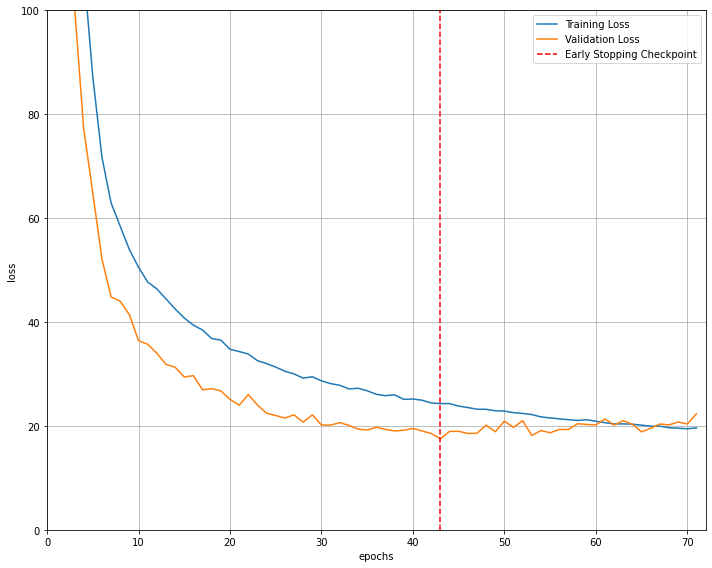

In [0]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 100) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [0]:
def test(net):
    predictions = []
    with torch.no_grad():
        for i, sample in enumerate(testloader):
            predict = []
            x ,y = sample
            x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
            
            x = x.to(device)
            y = y.to(device)
            
            a, b, y_p, d = net(x)

            #get class of a, b, d
            _, aa = a.max(1)
            _, bb = b.max(1)
            _, dd = d.max(1)

            aa = aa.to("cpu")
            bb = bb.to("cpu")
            y_p = y_p.to("cpu")
            dd = dd.to("cpu")

            predict.append(aa)
            predict.append(bb)
            predict.append(y_p)
            predict.append(dd)
            predict = np.array(predict)
            predictions.append(predict)
            

    #print(predictions)
    #print()
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, OUTPUT_LABEL_SIZE)
    df = DataFrame(predictions)
    df.to_excel('predictions.xlsx', header=None)

In [25]:
testsets = []
for f in tqdm(os.listdir(TEST_PATH_LABEL)):
  path  = os.path.join(TEST_PATH_LABEL, f)
  testset = DataCaller_Excel(path, IMG_SIZE)
  print(testset.__len__())
  testsets.append(testset)

testset = ConcatDataset(testsets)

100%|██████████| 1/1 [01:06<00:00, 66.88s/it]

1000


In [30]:
testloader = DataLoader(testset, batch_size=1, shuffle=False)
#trained_net = Net()x
trained_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
trained_net.to(device)
trained_net.eval()x
test(trained_net)

RuntimeError: ignored

In [32]:
testloader = DataLoader(testset, batch_size=1, shuffle=False)
#trained_net = Net()
load_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
load_net.to(device)
load_net.eval()
test(load_net)

NameError: ignored